In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [2]:
# Load and preprocess data
def Normalize(X):
    return X                       # TODO: Implement the normalization function


def load_data():
    # url_hospital = "https://archive.ics.uci.edu/ml/machine-learning-databases/haberman/haberman.data"
    data = pd.read_csv(
        "haberman.csv",
        header=None,
        names=["age", "year", "nodes_detected", "survival_status"],
    )
    X = data.iloc[:, :3].to_numpy()
    y = (data.iloc[:, 3] == 1).astype(int)  # Convert survival status to binary
    X = Normalize(X)

    return X, y

In [3]:
# Logistic function
def sigmoid(x):
    return x                        # TODO: Implement the sigmoid function

# Negative Log-Likelihood
def nll(beta, X, y):
    return np.inf                   # TODO: Implement NLL function


# Gradient of NLL
def gradient(beta, X, y):
    return np.zeros(X.shape[1])     # TODO: Implement the gradient of NLL


# Hessian of NLL
def hessian(beta, X):
    return np.eye(X.shape[1])       # TODO: Implement the hessian of NLL

In [4]:
# Newton-Raphson optimization
def newton_raphson(X, y, tol=1e-6, max_iter=100):
    beta = np.zeros(X.shape[1])    # TODO: Implement the Newton-Raphson optimization
    return beta

In [5]:
def predict(X, beta):
    return np.zeros(X.shape[0])    # TODO: Implement the prediction function

In [6]:
# Main workflow

# Load and preprocess data
X, y = load_data()

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train logistic regression model
beta = newton_raphson(X_train, y_train)

# Predictions and evaluation metrics for Newton Raphson
NP_preds = predict(X_test, beta)
NP_accuracy = accuracy_score(y_test, NP_preds)
NP_precision = precision_score(y_test, NP_preds)
NP_recall = recall_score(y_test, NP_preds)
NP_f1 = f1_score(y_test, NP_preds)

# Print metrics
print(f"Newton Raphson Accuracy: {NP_accuracy:.2f}")
print(f"Newton Raphson Precision: {NP_precision:.2f}")
print(f"Newton Raphson Recall: {NP_recall:.2f}")
print(f"Newton Raphson F1 Score: {NP_f1:.2f}")



Newton Raphson Accuracy: 0.29
Newton Raphson Precision: 0.00
Newton Raphson Recall: 0.00
Newton Raphson F1 Score: 0.00


/Users/javada/miniconda3/envs/FedStruct/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [7]:
# Train logistic regression model using sklearn
logreg = LogisticRegression(fit_intercept=True, solver="lbfgs")
logreg.fit(X_train, y_train)

# Predictions and evaluation metrics for Scikit Learn
SC_preds = logreg.predict(X_test)
SC_accuracy = accuracy_score(y_test, SC_preds)
SC_precision = precision_score(y_test, SC_preds)
SC_recall = recall_score(y_test, SC_preds)
SC_f1 = f1_score(y_test, SC_preds)
# Print metrics
print(f"Scikit Learn Accuracy: {SC_accuracy:.2f}")
print(f"Scikit Learn Precision: {SC_precision:.2f}")
print(f"Scikit Learn Recall: {SC_recall:.2f}")
print(f"Scikit Learn F1 Score: {SC_f1:.2f}")

Scikit Learn Accuracy: 0.69
Scikit Learn Precision: 0.73
Scikit Learn Recall: 0.91
Scikit Learn F1 Score: 0.81


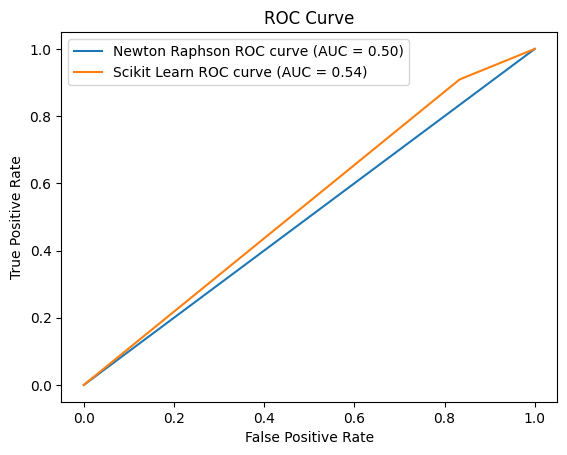

In [8]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, NP_preds)
fpr2, tpr2, _ = roc_curve(y_test, SC_preds)
roc_auc = auc(fpr, tpr)
roc_auc2 = auc(fpr2, tpr2)
plt.plot(fpr, tpr, label=f"Newton Raphson ROC curve (AUC = {roc_auc:.2f})")
plt.plot(fpr2, tpr2, label=f"Scikit Learn ROC curve (AUC = {roc_auc2:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [9]:
# Gradient of the negative log-posterior
def grad_neg_log_posterior(beta, X, y):
    return np.zeros(X.shape[1])     #TODO: Implement the gradient of Negative log-posterior


# Hessian of the negative log-posterior
def hessian_neg_log_posterior(beta, X):
    return np.eye(X.shape[1])       # TODO: Implement the hessian of Negative log-posterior

In [10]:
hessian = hessian_neg_log_posterior
gradient = grad_neg_log_posterior

# Train logistic regression model for Laplace approximation
LA_beta = newton_raphson(X_train, y_train)

# Predictions and evaluation metrics for Newton Raphson
LA_preds = predict(X_test, LA_beta)
LA_accuracy = accuracy_score(y_test, LA_preds)
LA_precision = precision_score(y_test, LA_preds)
LA_recall = recall_score(y_test, LA_preds)
LA_f1 = f1_score(y_test, LA_preds)

# Print metrics
print(f"Laplace approximation Accuracy: {LA_accuracy:.2f}")
print(f"Laplace approximation Precision: {LA_precision:.2f}")
print(f"Laplace approximation Recall: {LA_recall:.2f}")
print(f"Laplace approximation F1 Score: {LA_f1:.2f}")

Laplace approximation Accuracy: 0.29
Laplace approximation Precision: 0.00
Laplace approximation Recall: 0.00
Laplace approximation F1 Score: 0.00


/Users/javada/miniconda3/envs/FedStruct/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
